# Bank Marketing Data

### SECTION A - INTRODUCTION

### SECTION B - LIBRARIES

In [1]:
# Libs

# data structures
import pandas as pd
import numpy as np

# zSrv
# my custom functions
from ipynb.fs.full.Anchana_version2_functions import numvis_pipe, preproc, evalR, evalC, run_pca
# my folder path
from pathlib import Path
myfolder = Path("C:/Users/pdpc/Documents/MLfiles/Data/")

# graphs
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'

# train/test split
from sklearn.model_selection import train_test_split

# supress warning
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import FitFailedWarning 

# time function for timing program run
import time

# patch for overcoming 'float' error in nump 24.1v
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

# Classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# ColTransf / Pipeline / GridSearch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Evaluation

from sklearn.metrics import roc_auc_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay


### Sravan Katragadda's custom functions

Over the past years of enthusiastically learning Machine Learning through self-learning and courses,

I developed the below custom functions which I recurrently use in my Machine Learning methodologies & problem solving.

In [3]:
# Visualizing Classses of Data in 2D using PCA

def visualize_classes_in_pca(X,y):
    
    scaled_X = preprocessX(X)
    LE = LabelEncoder()
    scaled_y = LE.fit_transform(y)
    z = LE.classes_

    pca = PCA(n_components=2)
    X_reducedfeatures = pca.fit_transform(scaled_X)

    # Plotting in PCA Dimensions
    plt.figure(figsize=(10,8))
    plt.scatter(X_reducedfeatures[:,0],X_reducedfeatures[:,1], s = 8, c=scaled_y, label=z)
    plt.xlabel('First principle component')
    plt.ylabel('Second principle component')
    plt.title('Classes Visualization in 2D-PCA')
    plt.legend()
    
    # Evaluating PCA
    print("Preserved variance is: ", "%.2f" % (np.sum(pca.explained_variance_ratio_) * 100),"%")
    print("PCA features:          ", pca.explained_variance_ratio_)

In [4]:
# my custom function to remove the null values, duplicate values and outliers (using IQR method)

def datacleaner(df):
    
    # dataset size before clean up
    pre_size = df.shape[0]
    
    # Removing rows with null values
    df.dropna(inplace=True)
    
    # Removing duplicate rows
    df.drop_duplicates(keep='first', inplace=True)
    
    for col in df.select_dtypes(include='number'):
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df_out = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    # dataset size after clean up
    post_size = df_out.shape[0]
    
    print('Data Retention after clean up:' , "%.2f" % (post_size / pre_size * 100) , '%')
    print('Data lost in clean up        :' , "%.2f" % (100-(post_size / pre_size * 100)) , '%')
    return df_out  

In [5]:
# My custom function for Preprocessing X

def preprocessX(A):
    
    # features
    num_all_features = list(A.select_dtypes(include=['int64', 'float64']).columns.values)
    cat_all_features = list(A.select_dtypes(include=['object', 'category','bool']).columns.values)

    # Numerical Transformation
    num_transform = Pipeline (steps=[
                    ('imp', SimpleImputer(strategy='median')),
                    ('mms', MinMaxScaler())
                    ])

    # Categorical Operations
    cat_transform = Pipeline (steps=[
                    ('imp', SimpleImputer(strategy='constant',fill_value='missing')),
                    ('ore', OrdinalEncoder())
                    ])

    # Column Transformer (CT)
    preprocessor = ColumnTransformer(transformers=[
                    ('num_tran', num_transform, num_all_features),
                    ('cat_tran', cat_transform, cat_all_features),
                    ])
    
    B = preprocessor.fit_transform(A)
    
    return(B)

In [15]:
# my custom function for running multiple classifier models

def evalC(X,y):         
    
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    models = [LogisticRegression(),
              KNeighborsClassifier(),
              GradientBoostingClassifier(),
              SVC(),
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              AdaBoostClassifier(DecisionTreeClassifier()),
              ExtraTreesClassifier(),
              MLPClassifier(),
              LinearDiscriminantAnalysis()]
                   
    names  = ['LOG','KNN','GBC','SVC','DEC','RAF','ABC','ETC','MLP','LDA']

    precision = []
    recall = []
    f1 = []
    acc_train = []
    acc_test  = []
    
    for model,name in zip(models,names):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        precision_calc,recall_calc,f1score_calc,support_calc=score(y_test,y_pred,average='macro')
        precision.append("%.4f" % precision_calc)
        recall.append("%.4f" % recall_calc)
        f1.append("%.4f" % f1score_calc)
        
        acc_train.append("%.4f" % model.score(X_train, y_train))
        acc_test.append("%.4f" % model.score(X_test, y_test))  
                     
    # Getting results of Evaluation into a DF
    df_eval = pd.DataFrame({'precision':precision,'recall':recall,'f1':f1,'acc_train':acc_train,'acc_test':acc_test})
    df_eval = df_eval.T
    df_eval.columns = names
    return(df_eval)

### SECTION C - THE DATA

In [6]:
# Data

BerkAIdatafolder = Path("C:/Users/pdpc/Documents/MLfiles/Data/berkAIdata/")

data = pd.read_csv(BerkAIdatafolder / 'portugese bank data.csv')

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
# Quick Look at Data

print('BANK MARKETING DATA')
print("Dataset shape:  ",data.shape)
print("Dataset size:   ",data.size)
print("Null rows:      ",data.isnull().any(axis=1).sum())
print("Duplicate rows: ",data.duplicated().sum())
print("# of columns with numerical features  :   ",len(data.select_dtypes(include=['int64', 'float64']).columns.values))
print("# of columns with categorical features:   ",len(data.select_dtypes(include=['object', 'category']).columns.values))

BANK MARKETING DATA
Dataset shape:   (45211, 17)
Dataset size:    768587
Null rows:       0
Duplicate rows:  0
# of columns with numerical features  :    7
# of columns with categorical features:    10


In [8]:
# Lets count the Outliers per column in the data:

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()

age           487
balance      4729
campaign     3064
contact         0
day             0
default         0
duration     3235
education       0
housing         0
job             0
loan            0
marital         0
month           0
pdays        8257
poutcome        0
previous     8257
y               0
dtype: int64

<AxesSubplot:>

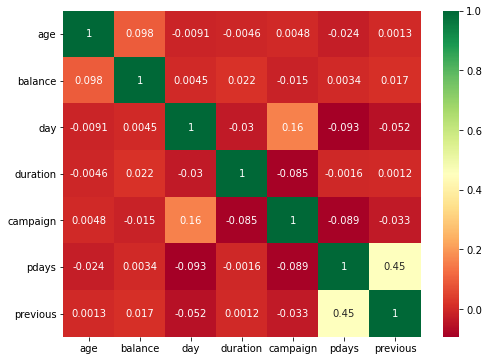

In [68]:
# Let's look at the correlation among numerical features

rcParams['figure.figsize'] = 8,6
sns.heatmap(data.corr(), annot=True, cmap ='RdYlGn')

<IPython.core.display.Javascript object>

Preserved variance is:  86.64 %
PCA features:           [0.48659152 0.37977376]


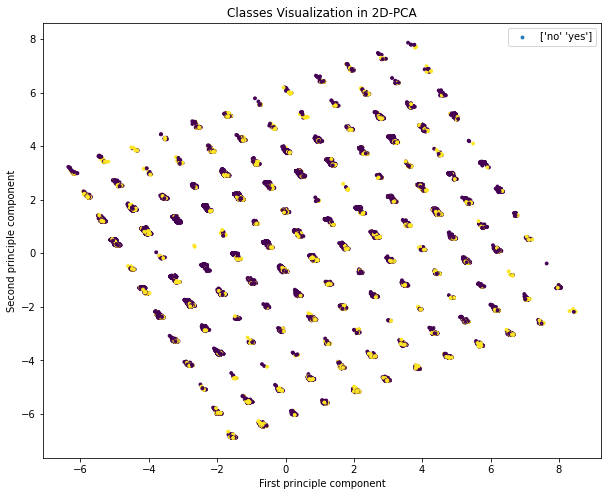

In [93]:
# Quick PCA visualization to understand how well the Classes are separated

# Identifying X & y for visualizing purposes
y_column = ["y"]
X  = data.drop(y_column, axis=1, errors='ignore')
y  = data[y_column].copy()

visualize_classes_in_pca(X,y)

### SECTION D - FEATURE ENGINEERING

In [9]:
# Removing null values, outliers, duplicate values

# I am using my custom developed function for this purpose

bankdata_cleaned = datacleaner(data)

Data Retention after clean up: 81.74 %
Data lost in clean up        : 18.26 %


In [10]:
# Identifying X & y

y_column = ['y']

# X/y split
bankdata_X  = bankdata_cleaned.drop(y_column, axis=1, errors='ignore')
bankdata_y  = bankdata_cleaned[y_column].copy()

In [11]:
# Preprocessing X & y

# Strategy for numerical features: imputation with median, scaling with MinMaxScaler
# Strategy for numerical features: imputation with constant, scaling with OrdinalEncoder

bankdata_X_preprocessed = preprocessX(bankdata_X)

bankdata_y_preprocessed = LabelEncoder().fit_transform(bankdata_y)

### SECTION E - MODELING & EVALUATION

In [17]:
tik = time.time() 

evaluation_baseline = evalC(bankdata_X_preprocessed, bankdata_y_preprocessed)

tok = time.time()

print('Time to run the baseline evaluation with multiple models:' , '%.2f' % (tok-tik) , 'seconds')

evaluation_baseline

Time to run the baseline evaluation with multiple models: 108.41 seconds


,LOG,KNN,GBC,SVC,DEC,RAF,ABC,ETC,MLP,LDA
precision,0.8007,0.6809,0.7790,0.4534,0.6733,0.7926,0.6692,0.7804,0.7869,0.7569
recall,0.5946,0.5544,0.6606,0.5000,0.6800,0.6536,0.6783,0.6092,0.6096,0.6578
f1,0.6316,0.5720,0.6992,0.4756,0.6766,0.6956,0.6736,0.6476,0.6487,0.6918
acc_train,0.9133,0.9256,0.9239,0.9088,1.0000,1.0000,1.0000,1.0000,0.9208,0.9141
acc_test,0.9165,0.9039,0.9194,0.9068,0.8885,0.9208,0.8866,0.9160,0.9167,0.9154


### SECTION F - HYPERPARAMETER FINETUNING

In [26]:
# Selecting Hyperparameters for All models

param_grid = {
    'Logistic Regression': {'penalty' : ['l1','l2'], 'solver': ['lbfgs', 'liblinear']},
    'KNN': {'n_neighbors': [5,10,15],'weights' : ['uniform', 'distance'],'p':[1,2]}
}

models = {'Logistic Regression': LogisticRegression(), 'KNN': KNeighborsClassifier()}

In [28]:
tik1 = time.time()

X_train, X_test, y_train, y_test = train_test_split(bankdata_X_preprocessed, bankdata_y_preprocessed, test_size = 0.2)

best_models = {}
best_params = {}

for name, model in models.items():
    
    tik = time.time()
    
    grid = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_
    best_params[name] = grid.best_params_
    
    tok = time.time()
    print('Time to run the GridSearch for' , name , 'is:' , '%.2f' % (tok-tik) , 'seconds')

tok1 = time.time()
print('Time to run the GridSearch evaluation for multiple models:' , '%.2f' % (tok1-tik1) , 'seconds')

Time to run the GridSearch for Logistic Regression is: 2.96 seconds
Time to run the GridSearch for KNN is: 47.53 seconds
Time to run the GridSearch evaluation for multiple models: 50.51 seconds


In [ ]:
# Now we have the best Hyperparameters for All models

### SECTION G - FINAL EVALUATION

In [ ]:
This is a final evaluation of all the models based on the best hyperparameters selected in Section F

In [149]:
# Running Evaluation metrics for all models with their best hyperparameters

recall = []
f1 = []
precision = []
acc_train = []
acc_test  = []
names  = ['Logistic Regression', 'KNN']


for name, model in best_models.items():
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    recall.append("%.4f" % recall_score(y_test, y_pred, average='binary'))
    f1.append("%.4f" % f1_score(y_test, y_pred, average='macro'))
    acc_train.append("%.4f" % model.score(X_train, y_train))
    acc_test.append("%.4f" % model.score(X_test, y_test))
    
    Df = pd.DataFrame({'recall':recall,'f1':f1,'acc_train':acc_train,'acc_test':acc_test})
    Df = Df.T

Df.columns = names
Df = Df.apply(pd.to_numeric, errors='coerce')

Df

,Logistic Regression,KNN
recall,0.1952,0.0946
f1,0.6254,0.5555
acc_train,0.9143,1.0000
acc_test,0.9161,0.9096


In [29]:

names  = ['Logistic Regression', 'KNN']

precision = []
recall = []
f1 = []
acc_train = []
acc_test  = []


for name, model in best_models.items():
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    precision_calc,recall_calc,f1score_calc,support_calc=score(y_test,y_pred,average='macro')
    
    precision.append("%.4f" % precision_calc)
    recall.append("%.4f" % recall_calc)
    f1.append("%.4f" % f1score_calc)
 
    acc_train.append("%.4f" % model.score(X_train, y_train))
    acc_test.append("%.4f" % model.score(X_test, y_test))
    
    
    
    Df = pd.DataFrame({'precision':precision,'recall':recall,'f1':f1,'acc_train':acc_train,'acc_test':acc_test})
    Df = Df.T

Df.columns = names
evaluation_final = Df.apply(pd.to_numeric, errors='coerce')

evaluation_final

,Logistic Regression,KNN
precision,0.7672,0.7208
recall,0.6071,0.5329
f1,0.6445,0.5407
acc_train,0.9132,0.9103
acc_test,0.9203,0.9141
